# X-ray 이미지로 폐렴 진단하기

- DNN을 활용해 폐렴 이미지를 구분한다. 

![image](https://user-images.githubusercontent.com/86637320/130712505-89911511-1c10-4726-b7a0-bdd710530ab4.png)

In [48]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

/aiffel/aiffel


## 1. 데이터 준비하기

val 데이터가 너무 적다!

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train과 val을 합친 다음에 랜덤으로 80:20 비율로 할당해준다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


**normal/pneumonia**는 폴더로 구분

In [6]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0627-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person569_bacteria_2360.jpeg


imbalanced 데이터 : pneumonia가 훨씬 많다.

In [7]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


**tf.data** - 학습 때 배치처리 작업을 보다 효율적으로 할 수 있다.

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy() #개수 세기
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


**Labeling**

file_path를 os.path.sep을 기준으로 split

In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 크기 조절, 라벨링

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

### Train/Val

AUTOTUNE 사용으로 빠르게 처리

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


### Test

In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat() #epoch 횟수만큼 repeat
    ds = ds.batch(BATCH_SIZE) 
    ds = ds.prefetch(buffer_size=AUTOTUNE) #학습 데이터 나눠서 읽어와 GPU에서 학습하는 동안 다음 데이터를 CPU에서 준비
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

show batch images

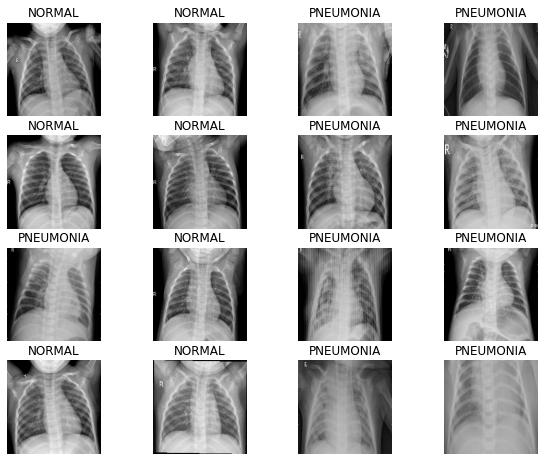

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 2. 모델 구성

Conv - Conv - BN - MaxPool

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

BN과 Dropout이 동시에 사용 => 도움이 될까?

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

**불균형**데이터 처리 : 가중치를 다르게 업데이트하자

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

## 3. 모델 훈련하기

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 54s 138ms/step - loss: 0.6281 - accuracy: 0.6672 - precision: 0.8971 - recall: 0.6325 - val_loss: 0.5835 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 131ms/step - loss: 0.2645 - accuracy: 0.8704 - precision: 0.9706 - recall: 0.8531 - val_loss: 0.9102 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 130ms/step - loss: 0.1886 - accuracy: 0.9176 - precision: 0.9797 - recall: 0.9086 - val_loss: 0.1171 - val_accuracy: 0.9558 - val_precision: 0.9852 - val_recall: 0.9542
Epoch 4/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1919 - accuracy: 0.9288 - precision: 0.9780 - recall: 0.9261 - val_loss: 0.0968 - val_accuracy: 0.9635 - val_precision: 0.9802 - val_recall: 0.9700
Epoch 5/25
261/261 [==============================] - 34s 130ms/step - loss: 0.1342 - accura

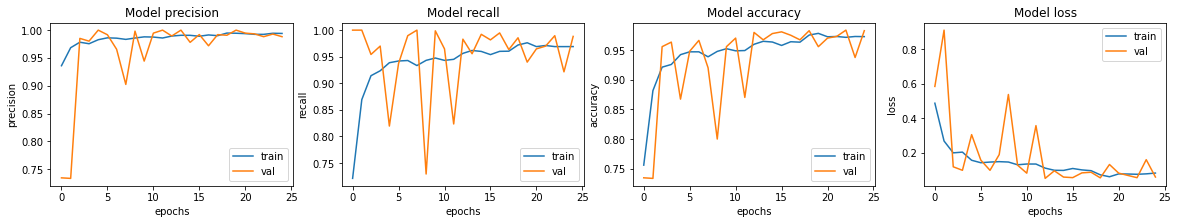

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

모델 평가

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 73ms/step - loss: 0.9963 - accuracy: 0.7901 - precision: 0.7486 - recall: 1.0000
Loss: 0.99632328748703,
Accuracy: 0.7900640964508057,
Precision: 0.7485604882240295,
Recall: 1.0


___

# 성능 개선

의료 데이터는 구하기 힘들기 때문에 data augmentation 진행 

Data Aumentation
- 이동, 회전, 가우시안 노이즈 추가한 이미지

이때 폐렴 이미지의 경우 가우시안 노이즈 적용 시 주의 필요

좌우/상하 반전 이미지만 추가로 사용하자

Dropout + BN ?

- 특이한 구조인데 정말 도움이 될까?

Val loss가 변동이 심한데 regularization 추가?

## 4. 성능 개선

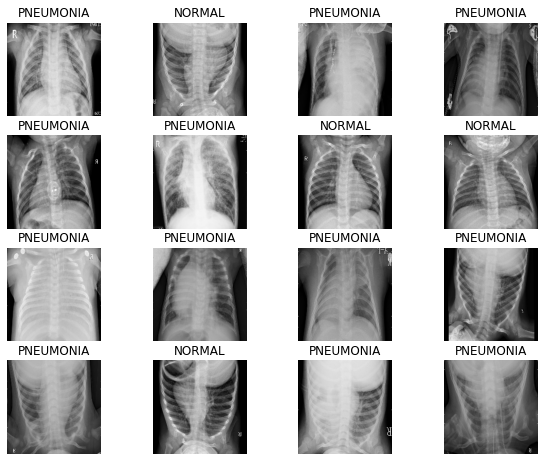

In [32]:
def augment1(image,label):
    
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label
    
def augment2(image,label):
    
    image = tf.image.random_flip_up_down(image)  # 랜덤하게 상하를 반전합니다.
    return image,label
    
def prepare_for_training(ds, shuffle_buffer_size=1000):
        
    ds = ds.map(augment1,num_parallel_calls=2)
    ds = ds.map(augment2,num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat() #epoch 횟수만큼 repeat
    ds = ds.batch(BATCH_SIZE) 
    ds = ds.prefetch(buffer_size=AUTOTUNE) #학습 데이터 나눠서 읽어와 GPU에서 학습하는 동안 다음 데이터를 CPU에서 준비
    return ds

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
    
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    
train_ds = prepare_for_training(train_ds)

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [67]:
def modify_params(BATCH_SIZE = 16,epoches = 25,optimizer = 'adam',rugularizer = 0,class_weight = class_weight,augment = True):
    
    # 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
    def get_label(file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

    # 이미지를 알맞은 형식으로 바꿉니다.
    def decode_img(img):
        img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
        img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
        img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
        return img

    # 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
    def process_path(file_path):
        label = get_label(file_path) # 라벨 검출
        img = tf.io.read_file(file_path) # 이미지 읽기
        img = decode_img(img) # 이미지를 알맞은 형식으로 수정
        return img, label
    
    def augment1(image,label):
        image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
        return image,label
    
    def augment2(image,label):
        image = tf.image.random_flip_up_down(image)  # 랜덤하게 상하를 반전합니다.
        return image,label
    
    def prepare_for_training(ds, shuffle_buffer_size=1000):
        
        ds = ds.map(augment1,num_parallel_calls=2)
        ds = ds.map(augment2,num_parallel_calls=2)
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        ds = ds.repeat() #epoch 횟수만큼 repeat
        ds = ds.batch(BATCH_SIZE) 
        ds = ds.prefetch(buffer_size=AUTOTUNE) #학습 데이터 나눠서 읽어와 GPU에서 학습하는 동안 다음 데이터를 CPU에서 준비
        return ds
    
    train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
    val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
    
    train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    
    train_ds = prepare_for_training(train_ds)
    val_ds = prepare_for_training(val_ds)
    
    test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
    TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
    test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.batch(BATCH_SIZE)
    
    
    #model
    def conv_block(filters):
        block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
        return block
    
    def dense_block(units, dropout_rate):
        block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate)
    ])
    
        return block
    
    def build_model():
        model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
        return model
    
    with tf.device('/GPU:0'):
        model = build_model()
        
        earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=4,         # 4회 Epoch동안 개선되지 않는다면 종료
                             )

        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
                    ]
    
        model.compile(
            optimizer= optimizer,
            loss='binary_crossentropy',
            metrics=METRICS
                    )
    
        history = model.fit(
            train_ds,
            steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=val_ds,
            validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
            class_weight=class_weight,
            callbacks = earlystopping
                            )
    
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')
    
    eval_result = {'loss' : loss, 'accuracy' : accuracy, 'precision' : precision, 'recall' : recall}
    
    return history, eval_result

In [55]:
def plot(history):

    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

#### 모델1 : BATCH_SIZE = 16,epoches = 25,optimizer = 'adam',rugularizer = 0,class_weight = class_weight,augment = True

In [49]:
model1 = modify_params()

Epoch 1/25
261/261 [==============================] - 42s 133ms/step - loss: 0.5973 - accuracy: 0.6810 - precision: 0.8906 - recall: 0.6537 - val_loss: 0.6506 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 129ms/step - loss: 0.2780 - accuracy: 0.8885 - precision: 0.9693 - recall: 0.8777 - val_loss: 1.1376 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 129ms/step - loss: 0.2873 - accuracy: 0.8890 - precision: 0.9658 - recall: 0.8835 - val_loss: 0.1368 - val_accuracy: 0.9510 - val_precision: 0.9851 - val_recall: 0.9477
Epoch 4/25
261/261 [==============================] - 34s 131ms/step - loss: 0.2110 - accuracy: 0.9146 - precision: 0.9749 - recall: 0.9084 - val_loss: 0.1335 - val_accuracy: 0.9510 - val_precision: 0.9811 - val_recall: 0.9516
Epoch 5/25
261/261 [==============================] - 34s 129ms/step - loss: 0.1989 - accura

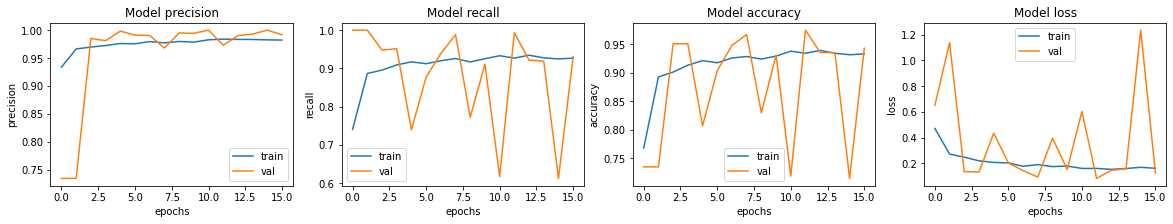

In [56]:
plot(model1[0])

#### 모델2 : BATCH_SIZE = 32,epoches = 25,optimizer = 'adam',rugularizer = 0,class_weight = class_weight,augment = True

In [58]:
model2 = modify_params(BATCH_SIZE = 32)

Epoch 1/25
130/130 [==============================] - 40s 249ms/step - loss: 0.6037 - accuracy: 0.7085 - precision: 0.9001 - recall: 0.6798 - val_loss: 0.5884 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 32s 245ms/step - loss: 0.2931 - accuracy: 0.8912 - precision: 0.9747 - recall: 0.8781 - val_loss: 0.7391 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 32s 243ms/step - loss: 0.2328 - accuracy: 0.9095 - precision: 0.9735 - recall: 0.9030 - val_loss: 0.8406 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 31s 241ms/step - loss: 0.2099 - accuracy: 0.9224 - precision: 0.9755 - recall: 0.9187 - val_loss: 1.0040 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/25
20/20 [==============================] - 3s 143ms/step - loss: 1.2387 - accuracy:

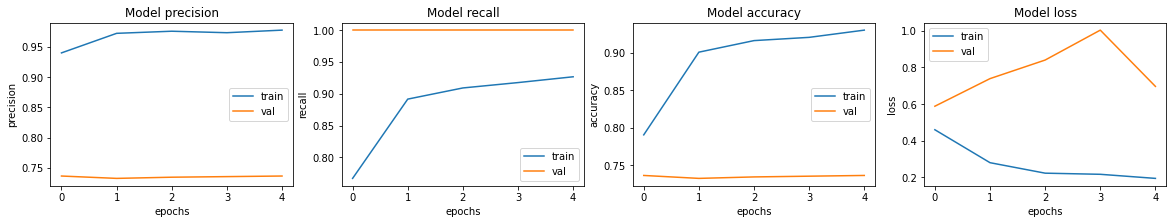

In [59]:
plot(model2[0])

#### 모델3 : BATCH_SIZE = 8,epoches = 25,optimizer = 'adam',rugularizer = 0,class_weight = class_weight,augment = True

In [60]:
model3 = modify_params(BATCH_SIZE = 8)

Epoch 1/25
523/523 [==============================] - 64s 74ms/step - loss: 0.5516 - accuracy: 0.7237 - precision: 0.9005 - recall: 0.7052 - val_loss: 0.5821 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
523/523 [==============================] - 38s 73ms/step - loss: 0.3786 - accuracy: 0.8355 - precision: 0.9488 - recall: 0.8222 - val_loss: 0.4435 - val_accuracy: 0.8010 - val_precision: 0.7866 - val_recall: 1.0000
Epoch 3/25
523/523 [==============================] - 38s 73ms/step - loss: 0.3595 - accuracy: 0.8412 - precision: 0.9547 - recall: 0.8279 - val_loss: 2.9670 - val_accuracy: 0.3115 - val_precision: 1.0000 - val_recall: 0.0616
Epoch 4/25
523/523 [==============================] - 38s 73ms/step - loss: 0.3414 - accuracy: 0.8431 - precision: 0.9496 - recall: 0.8333 - val_loss: 0.3489 - val_accuracy: 0.8337 - val_precision: 0.8202 - val_recall: 0.9908
Epoch 5/25
523/523 [==============================] - 38s 72ms/step - loss: 0.3123 - accuracy: 0

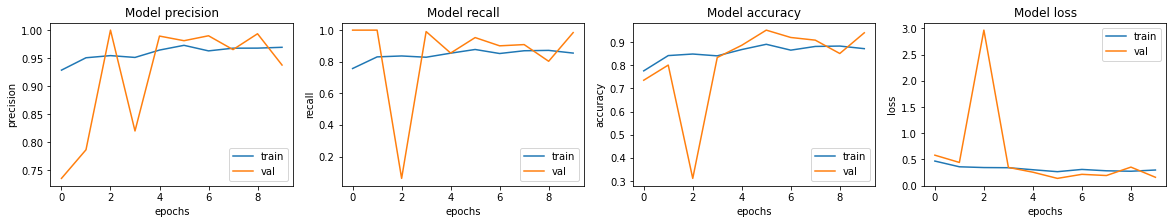

In [61]:
plot(model3[0])

#### model4 Dropout없이 BN만 진행했을 경우

#### 모델4 : BATCH_SIZE = 8,epoches = 25,optimizer = 'adam',rugularizer = 0,class_weight = class_weight,augment = True

In [63]:
model4 = modify_params(BATCH_SIZE = 8)

Epoch 1/25
523/523 [==============================] - 46s 74ms/step - loss: 0.4987 - accuracy: 0.7554 - precision: 0.9262 - recall: 0.7267 - val_loss: 0.7317 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
523/523 [==============================] - 38s 72ms/step - loss: 0.2823 - accuracy: 0.8727 - precision: 0.9640 - recall: 0.8611 - val_loss: 3.8651 - val_accuracy: 0.2663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
523/523 [==============================] - 37s 72ms/step - loss: 0.2671 - accuracy: 0.8894 - precision: 0.9733 - recall: 0.8767 - val_loss: 0.4107 - val_accuracy: 0.7913 - val_precision: 0.7792 - val_recall: 1.0000
Epoch 4/25
523/523 [==============================] - 38s 72ms/step - loss: 0.2617 - accuracy: 0.8965 - precision: 0.9716 - recall: 0.8874 - val_loss: 0.4878 - val_accuracy: 0.7154 - val_precision: 1.0000 - val_recall: 0.6141
Epoch 5/25
523/523 [==============================] - 38s 73ms/step - loss: 0.2352 - acc

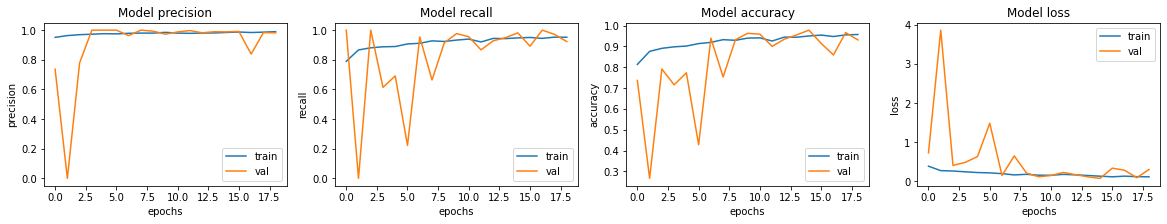

In [64]:
plot(model4[0])

#### model5  BN없이 Dropout을 진행했을 경우

In [65]:
model5 = modify_params()

Epoch 1/25
261/261 [==============================] - 42s 133ms/step - loss: 0.3889 - accuracy: 0.8140 - precision: 0.9567 - recall: 0.7846 - val_loss: 0.6180 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 130ms/step - loss: 0.2194 - accuracy: 0.9090 - precision: 0.9729 - recall: 0.9029 - val_loss: 1.0698 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1957 - accuracy: 0.9216 - precision: 0.9781 - recall: 0.9149 - val_loss: 0.2431 - val_accuracy: 0.9087 - val_precision: 0.9912 - val_recall: 0.8837
Epoch 4/25
261/261 [==============================] - 34s 129ms/step - loss: 0.1883 - accuracy: 0.9285 - precision: 0.9772 - recall: 0.9258 - val_loss: 0.1413 - val_accuracy: 0.9481 - val_precision: 0.9427 - val_recall: 0.9895
Epoch 5/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1523 - accura

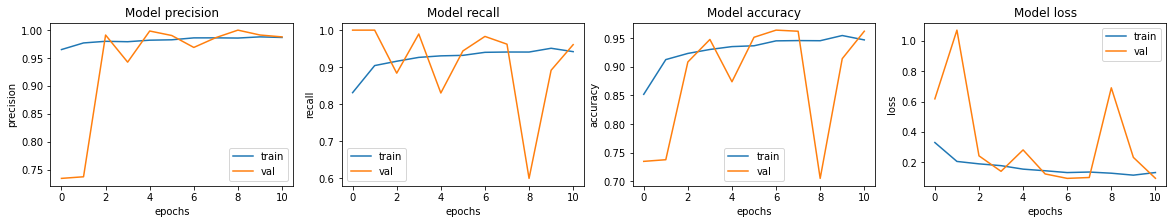

In [66]:
plot(model5[0])

#### model6 Dropout만 진행했을 경우

#### 모델6 : BATCH_SIZE = 8,epoches = 25,optimizer = 'adam',rugularizer = 0,class_weight = class_weight,augment = True

In [68]:
model6 = modify_params(BATCH_SIZE = 8)

Epoch 1/25
523/523 [==============================] - 44s 72ms/step - loss: 0.4804 - accuracy: 0.7554 - precision: 0.9005 - recall: 0.7558 - val_loss: 1.2296 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
523/523 [==============================] - 37s 71ms/step - loss: 0.3672 - accuracy: 0.8463 - precision: 0.9665 - recall: 0.8212 - val_loss: 1.3799 - val_accuracy: 0.7375 - val_precision: 0.7367 - val_recall: 1.0000
Epoch 3/25
523/523 [==============================] - 37s 71ms/step - loss: 0.3331 - accuracy: 0.8710 - precision: 0.9733 - recall: 0.8493 - val_loss: 0.8283 - val_accuracy: 0.3894 - val_precision: 1.0000 - val_recall: 0.1710
Epoch 4/25
523/523 [==============================] - 37s 71ms/step - loss: 0.2510 - accuracy: 0.8782 - precision: 0.9736 - recall: 0.8605 - val_loss: 0.3667 - val_accuracy: 0.8019 - val_precision: 0.9964 - val_recall: 0.7330
Epoch 5/25
523/523 [==============================] - 37s 71ms/step - loss: 0.2337 - accuracy: 0

#### model7 class_weight 없을 경우

##### 모델7 : BATCH_SIZE = 8,epoches = 25,optimizer = 'adam',rugularizer = 0,class_weight = False,augment = True

In [69]:
model7 = modify_params(BATCH_SIZE = 8,class_weight = {0:1,1:1})

Epoch 1/25
523/523 [==============================] - 45s 73ms/step - loss: 0.4344 - accuracy: 0.8051 - precision: 0.8453 - recall: 0.9091 - val_loss: 1.9560 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
523/523 [==============================] - 37s 71ms/step - loss: 0.2688 - accuracy: 0.8826 - precision: 0.9313 - recall: 0.9082 - val_loss: 0.3368 - val_accuracy: 0.7923 - val_precision: 0.7802 - val_recall: 0.9987
Epoch 3/25
523/523 [==============================] - 37s 71ms/step - loss: 0.2458 - accuracy: 0.9042 - precision: 0.9449 - recall: 0.9259 - val_loss: 2.8863 - val_accuracy: 0.2654 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
523/523 [==============================] - 37s 71ms/step - loss: 0.2307 - accuracy: 0.9184 - precision: 0.9540 - recall: 0.9353 - val_loss: 1.1220 - val_accuracy: 0.2635 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
523/523 [==============================] - 37s 71ms/step - loss: 0.21

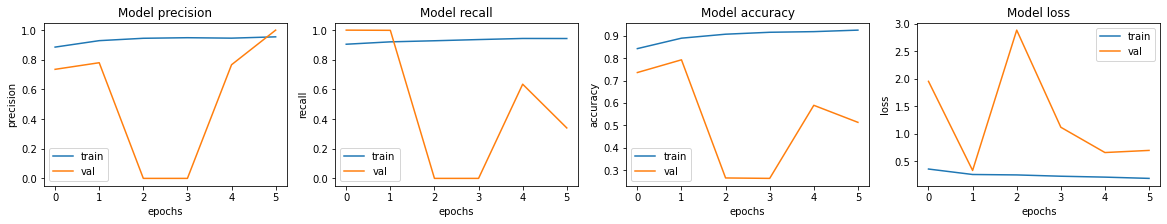

In [70]:
plot(model7[0])

___

# 정리

- 폐 X-ray 사진을 통해 폐렴 이미지를 구분해보았다.

- 모델 다양한 parameters을 바꿔가며 영향을 확인해보았다.

의료 이미지의 경우 데이터가 적기 때문에 기존 이미지를 상하,좌우 반전시켜 얻은 추가적인 데이터를 활용해서 모델을 개선했다.

이처럼 단순 **data augmentation**만 진행했을 때 accuracy는 기존 80%에서 83%로 성능 개선을 확인할 수 있었다.

85%까지 성능을 개선하기 위해서 Dropout + BN 레이어에서 둘 중 하나를 제거해본 결과 BN 레이어만 있을 때가 더 좋은 결과를 얻었다.

결과적으로 accuracy를 85%까지 늘릴 수 있었다.

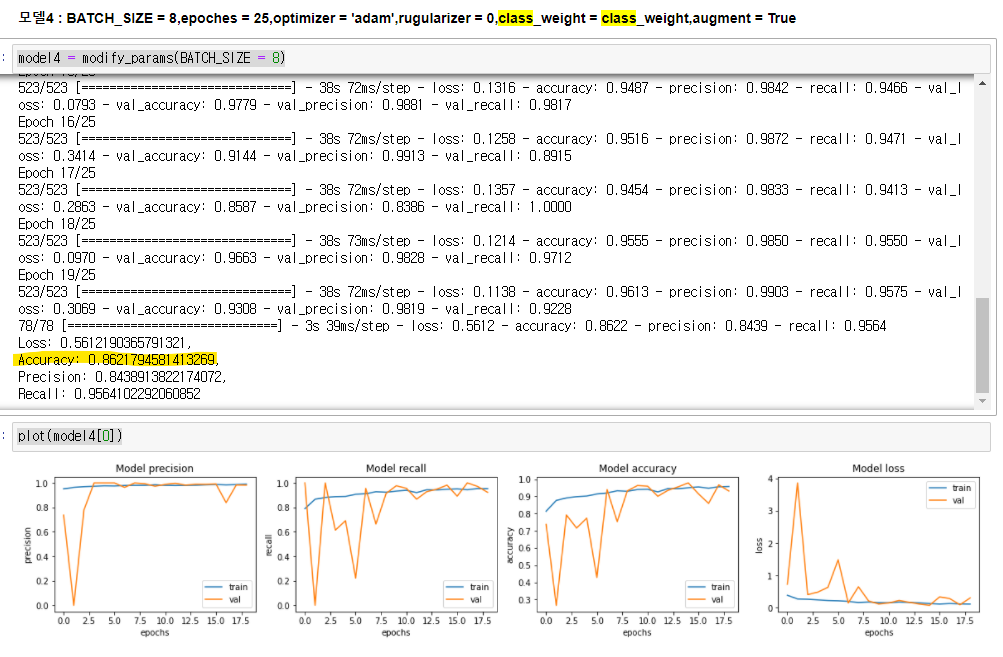

폐렴/정상 이미지가 불균형해 가중치를 조절해줬는데 이를 없애니 성능이 많이 나빠짐을 확인했다.

___